In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset

In [2]:
df_full = pd.read_csv('hippoCorpusV2.csv')
df = pd.read_csv('hippoCorpusV2.csv')

# Clean data

In [3]:
# Are there missing values in the train set?
df.isnull().sum()

AssignmentId            0
WorkTimeInSeconds       0
WorkerId                0
annotatorAge           23
annotatorGender         0
annotatorRace           0
distracted              0
draining                0
frequency            2756
importance            144
logTimeSinceEvent       0
mainEvent               0
memType                 0
mostSurprising          0
openness                0
recAgnPairId         4235
recImgPairId         1526
similarity           4098
similarityReason     4098
story                   0
stressful               0
summary                 0
timeSinceEvent          0
dtype: int64

In [4]:
# Okay, lots of missing values. Filling them with the mean value of the column
df["annotatorAge"] = df["annotatorAge"].fillna(df["annotatorAge"].mean())
df["frequency"] = df["frequency"].fillna(df["frequency"].mean())
df["importance"] = df["importance"].fillna(df["importance"].mean())
df["similarity"] = df["similarity"].fillna(df["similarity"].mean())

In [5]:
# Let's see if it worked
df.isnull().sum()

AssignmentId            0
WorkTimeInSeconds       0
WorkerId                0
annotatorAge            0
annotatorGender         0
annotatorRace           0
distracted              0
draining                0
frequency               0
importance              0
logTimeSinceEvent       0
mainEvent               0
memType                 0
mostSurprising          0
openness                0
recAgnPairId         4235
recImgPairId         1526
similarity              0
similarityReason     4098
story                   0
stressful               0
summary                 0
timeSinceEvent          0
dtype: int64

In [6]:
# sklearn does not like columns with categorical values
# make them binary dummy variables instead
df = pd.get_dummies(df, columns=["annotatorGender", "annotatorRace"])

In [7]:
# make labels column using numerical values
df.memType = pd.Categorical(df.memType)
df['label'] = df.memType.cat.codes

# story type corresponding to label
print(f"Label 0: {df.loc[df['label'] == 0,'memType'].unique()}")
print(f"Label 1: {df.loc[df['label'] == 1,'memType'].unique()}")
print(f"Label 2: {df.loc[df['label'] == 2,'memType'].unique()}")

Label 0: ['imagined']
Categories (1, object): ['imagined']
Label 1: ['recalled']
Categories (1, object): ['recalled']
Label 2: ['retold']
Categories (1, object): ['retold']


In [8]:
# drop categorical column
df = df.drop(columns='memType')

In [9]:
# AssignmentId, WorkerId, recAgnPairId and recImgPairId are practically unique for each individual and thus unusable for predictions
# mainEvent, mostSurprising, similarityReason, story and summary contain text and are unique to each individual
uninformative_cols = ["AssignmentId", "WorkerId", "recAgnPairId", "recImgPairId"]
text_cols = ["mainEvent", "mostSurprising", "similarityReason", "story", "summary"]
df = df.drop(columns=uninformative_cols)
df = df.drop(columns=text_cols)

In [10]:
# age as binary measures
df['Old'] = np.where(df['annotatorAge']>=44, 1, 0)
df['Young'] = np.where(df['annotatorAge']>=25, 0, 1)
df['Middle1'] = np.where((df['annotatorAge']>=33) & (df['annotatorAge'] >=25), 1, 0)
df['Middle2'] = np.where((df['annotatorAge']>=44) & (df['annotatorAge'] >=33), 1, 0)

In [61]:
# drop columns made into binary measures ? (better with both binary and continuous variables)
#newbin_cols = ["annotatorAge"]
#df = df.drop(columns=newbin_cols)

In [11]:
# drop race columns
# variable doesn't make much difference kept/dropped
race = ["annotatorRace_asian", "annotatorRace_black", "annotatorRace_hisp", "annotatorRace_indian", "annotatorRace_islander", "annotatorRace_middleEastern", "annotatorRace_na", "annotatorRace_native", "annotatorRace_other", "annotatorRace_white"]
df = df.drop(columns=race)

# Inspect data visually

<AxesSubplot:>

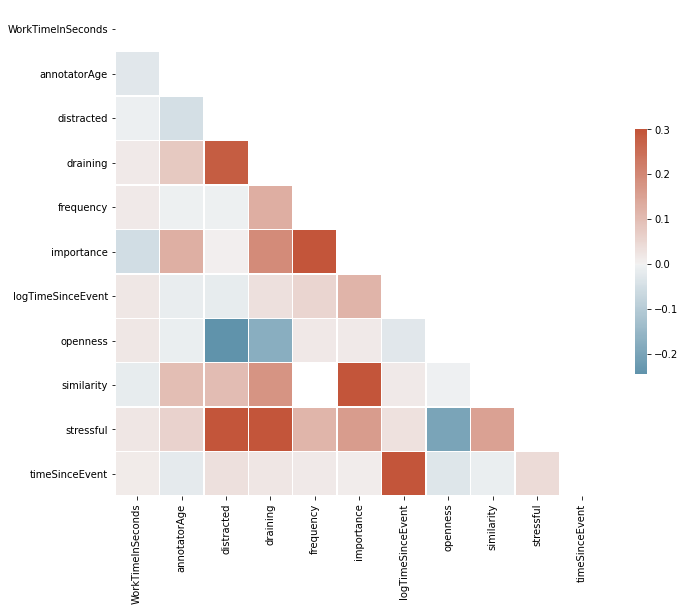

In [12]:
# Compute the correlation matrix
corr = df_full.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:xlabel='annotatorGender', ylabel='count'>

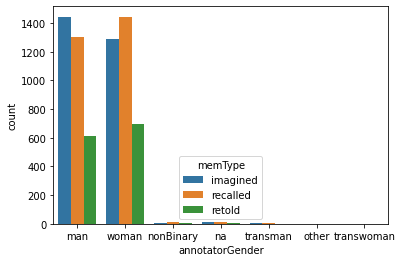

In [13]:
# histogram of gender and story type
sns.countplot(x="annotatorGender", hue="memType", data=df_full)

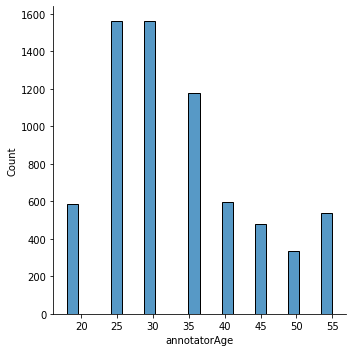

In [14]:
# age distribution
sns.displot(df_full, x="annotatorAge")

[Text(0.5, 0, 'annotatorGender')]

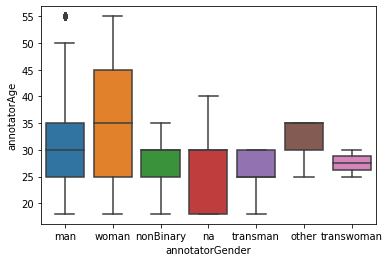

In [15]:
# Boxplot of age and sex
ax = sns.boxplot(x="annotatorGender", y="annotatorAge", data=df_full)
ax.set(xlabel="annotatorGender")

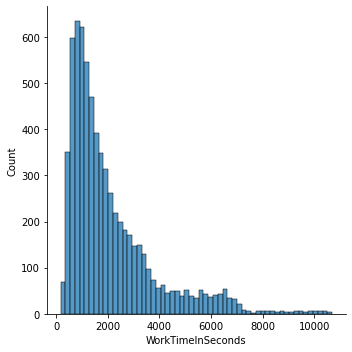

In [16]:
# WorkTimeInSeconds distribution
sns.displot(df_full, x="WorkTimeInSeconds")

# Split into testing and training data

In [17]:
# split df into test and train
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

# Logistic Regression model

In [18]:
# Creating a good old logistic regression model based on the remaining columns
model = LogisticRegression()
# Make subset of training data containing everything except the label
X = train.loc[:, train.columns != "label"]
# Make subset containing only the label
Y = train["label"]

# Fit model on training data
model.fit(X, Y)
# See how well the model does on the training data
yhat = model.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

Accuracy on train data: 0.4022801302931596


array([[2223,    0,    0],
       [2247,    0,    0],
       [1056,    0,    0]])

In [19]:
# Test the model on the testing set
X_test = test.loc[:, train.columns != "label"]
Y_test = test["label"]

yhat_test = model.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on test data: 0.401355421686747


array([[533,   0,   0],
       [532,   0,   0],
       [263,   0,   0]])

In [20]:
print(classification_report(Y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57       533
           1       0.00      0.00      0.00       532
           2       0.00      0.00      0.00       263

    accuracy                           0.40      1328
   macro avg       0.13      0.33      0.19      1328
weighted avg       0.16      0.40      0.23      1328



# Ridge classifier

In [21]:
# Regularisation: Ridge classifier
model_rid = RidgeClassifier()

# Fit model on training data
model_rid.fit(X, Y)

# See how well the model does on the training data
yhat = model_rid.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

# Test the model on the testing set
X_test = test.loc[:, train.columns != "label"]
Y_test = test["label"]

yhat_test = model_rid.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on train data: 0.6606948968512486
Accuracy on test data: 0.6355421686746988


array([[406, 127,   0],
       [ 88, 413,  31],
       [ 73, 165,  25]])

In [22]:
# Cross-validation - 10fold
scores_rid = cross_val_score(model_rid, X, Y, cv=10)
print('Cross-Validation Accuracy Scores', scores_rid)

scores_rid = pd.Series(scores_rid)
scores_rid.min(), scores_rid.mean(), scores_rid.max()

Cross-Validation Accuracy Scores [0.6437613  0.68535262 0.65461121 0.64918626 0.67811935 0.67811935
 0.66123188 0.63949275 0.64855072 0.63224638]


(0.6322463768115942, 0.6570671829546347, 0.6853526220614828)

In [23]:
print(classification_report(Y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       533
           1       0.59      0.78      0.67       532
           2       0.45      0.10      0.16       263

    accuracy                           0.64      1328
   macro avg       0.58      0.54      0.52      1328
weighted avg       0.61      0.64      0.59      1328

